## Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой

In [24]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

from sklearn import set_config
set_config(transform_output='pandas')

plt.style.use('seaborn') # установка стиля matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Знакомство с данными**

Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/12aeb6a8af2d5cdf500e55d3ccbb9f8e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/insurance.zip).

In [26]:
load_data = pd.read_csv('data\insurance.zip')

In [27]:
data = load_data.copy()
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [28]:
TARGET_FEATURE = 'charges'

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [30]:
# Количество пропусков в признаках
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [31]:
# Типы признаков
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [32]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Целевой признак нужно конвертировать в целый. Точность тут излишняя.

In [33]:
# data[TARGET_FEATURE] = data[TARGET_FEATURE].round().astype('int')

In [34]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [35]:
# # кодируем бинарные категориальные признаки
# data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
# data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

# # оставшиеся категориальные признаки кодируем с помощью OneHotEncoder
# # нужно проверить результаты с drop_first и без
# data = pd.get_dummies(data, drop_first=True)

In [36]:
data = pd.get_dummies(data, columns=['smoker', 'sex', 'region'], drop_first=True)

In [37]:
data

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,False,True,False
2,28,33.000,3,4449.46200,False,True,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,False,True,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


In [38]:
# Разделение выборки на матрицу признаков и вектор правильных ответов
X = data.drop(columns=TARGET_FEATURE)
y = data[TARGET_FEATURE]

In [39]:
# Разделение выборок на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Чему равно количество наблюдений в тестовом наборе данных?

In [40]:
X_test.shape[0]

268

In [41]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

# Обучаем модель - ищем параметры/ подбираем коэффициенты
lr.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [42]:
round(lr.intercept_, 2)

-11931.22

-11931.22

In [43]:
hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
R^2: 0.742
MAE: 4208.235
MAPE: 42.203

*** TEST ***
R^2: 0.784
MAE: 4181.194
MAPE: 46.888


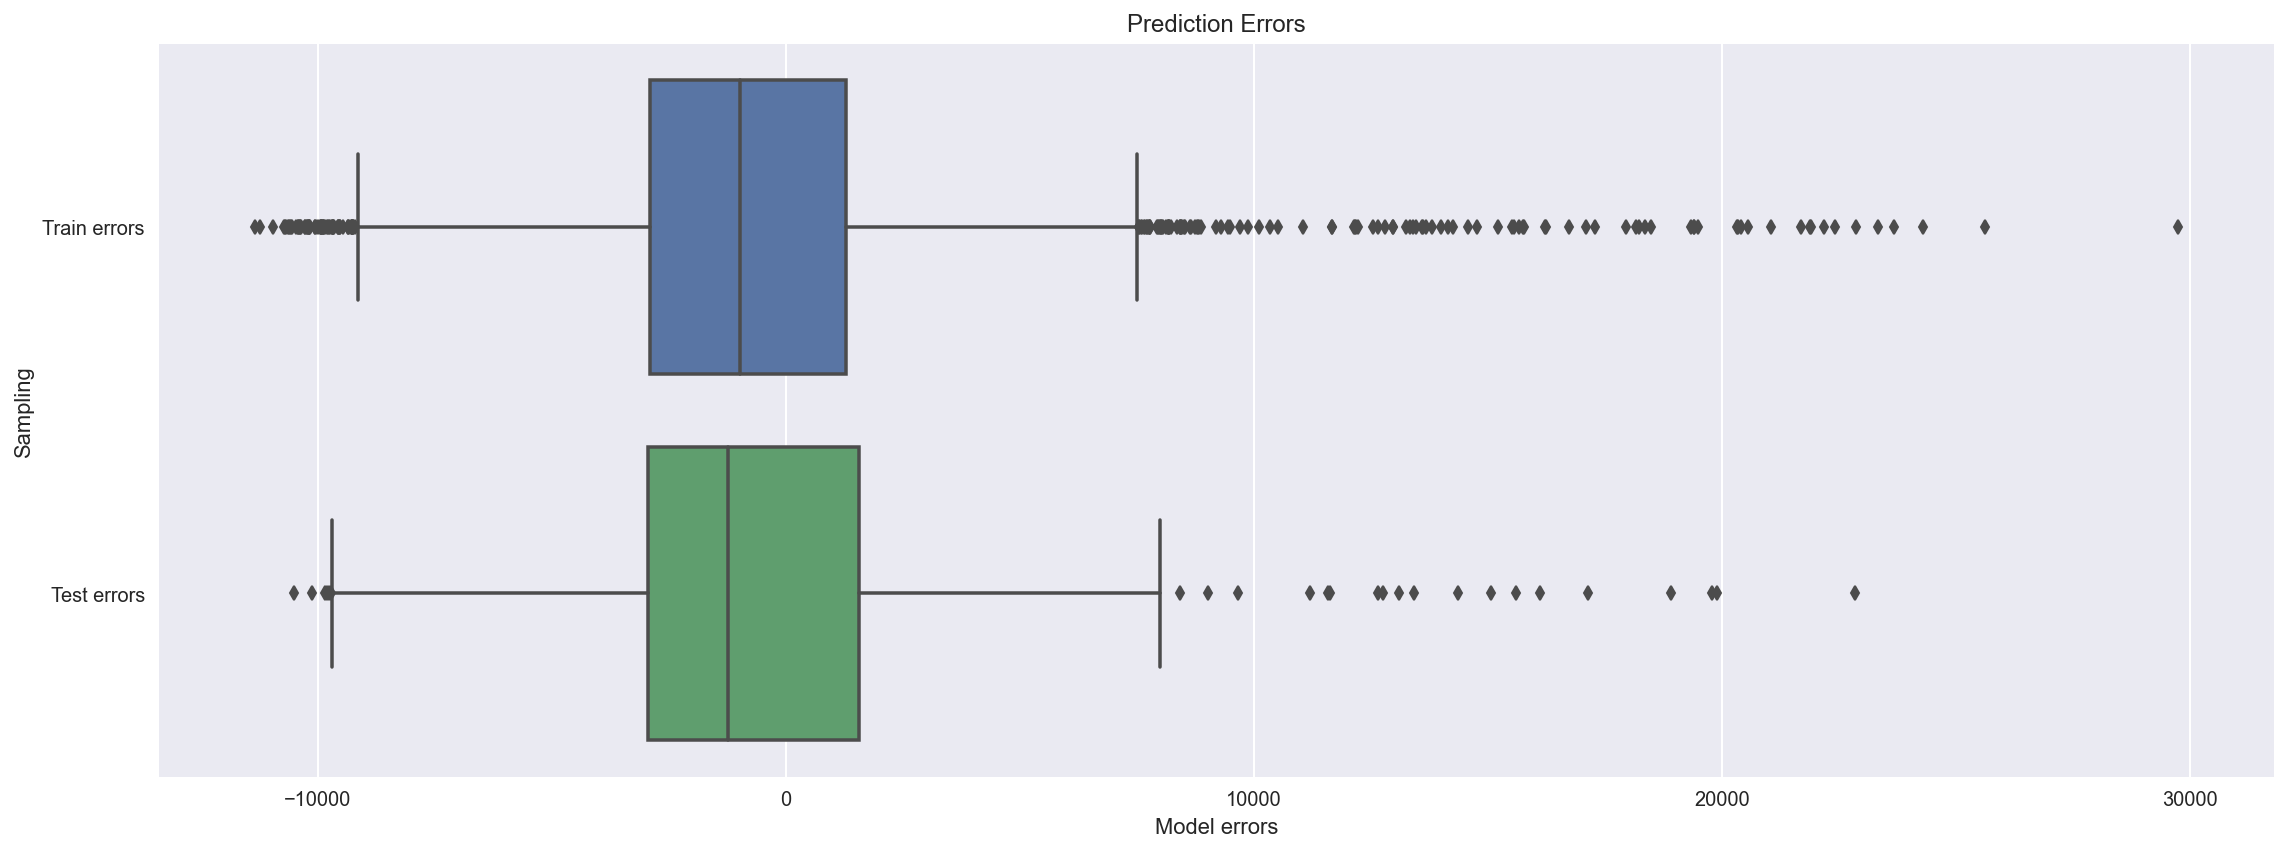

In [44]:
hd.plot_errors_boxplot(y_train, y_train_pred, y_test, y_test_pred)

На тестовой выборке все же коробка и усы больше чем на тренировочной, а вот вылетов меньше.

In [45]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()

# Вычисляем параметры для нормализации - min и max для каждого столбца
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Вычисляем параметры генерации - результирующее количество признаков
# Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 44)
Test shape: (268, 44)


In [46]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
R^2: 0.823
MAE: 3209.988
MAPE: 35.395

*** TEST ***
R^2: 0.848
MAE: 3067.805
MAPE: 35.363


Метрики выглядят хорошо если сравнивать тренировочную и тестовую выборки, на тестовой выборке метрики лучше.

Но посмотрим на коэффициенты модели.

In [48]:
lr_poly.coef_

array([ 2.00132815e+03,  2.34673202e+02,  2.59838854e+03,  5.78222170e+15,
       -1.73287176e+15,  3.15021191e+17, -8.96580478e+16, -6.86135477e+16,
        8.72154916e+03,  3.12119719e+03, -7.57044207e+03,  3.02224343e+02,
        4.28568525e+02,  1.50770873e+03,  4.35495918e+03, -1.54623055e+02,
        1.37773036e+03,  2.01500823e+04,  5.05722287e+04,  1.57164244e+03,
       -6.58416157e+03, -9.53098691e+03, -1.02627909e+04,  1.28688235e+03,
        3.80439863e+03, -3.91094397e+03, -1.29831881e+03, -6.56497518e+03,
       -4.83204363e+03, -5.78222170e+15,  4.77443066e+02, -4.58202163e+03,
       -4.54141348e+03, -3.41769735e+03,  1.73287176e+15,  3.79300912e+03,
        3.93108277e+03,  3.17035841e+03, -3.15021191e+17,  0.00000000e+00,
        0.00000000e+00,  8.96580478e+16,  0.00000000e+00,  6.86135477e+16])

Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация. За 10ку коэффициенты заходят.

### Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. 
В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

In [49]:
# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)

# Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.842
MAE: 2890.219
MAPE: 29.427

*** TEST ***
R^2: 0.867
MAE: 2716.636
MAPE: 30.155


In [50]:
lasso_lr_poly.coef_

array([ 2.30658606e+03,  8.13414276e+03,  6.47841444e+03,  2.50248313e+03,
       -0.00000000e+00, -8.63384149e+02, -0.00000000e+00, -1.02792681e+03,
        8.30553039e+03,  8.61691898e+02, -1.21062346e+03,  1.59728918e+02,
        7.56916257e+02,  8.57682526e+02,  2.06024358e+03,  2.52146828e+03,
       -8.05105039e+03,  1.22341596e+03,  5.47903855e+04,  5.34963266e+02,
       -2.67573375e+02, -4.27735920e+03, -2.99705714e+03, -1.65826498e+03,
       -2.04610309e+03, -1.12980145e+03,  5.29110431e+01, -1.84040497e+03,
       -2.95599796e+03,  1.53883810e+01,  2.65946422e+02, -5.43641678e+02,
       -8.17536892e+02,  1.40434546e+03, -1.65354620e+03,  1.14697267e+03,
        1.37908579e+03,  5.39967193e+02, -6.35805289e+02,  0.00000000e+00,
        0.00000000e+00, -2.15797864e+02,  0.00000000e+00, -1.41156636e+02])

Степени коэффициентов вполне нормальные

### Пробуем L2 регуляризацию

In [51]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()

# Обучаем модель 
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.838
MAE: 2947.785
MAPE: 29.548

*** TEST ***
R^2: 0.864
MAE: 2853.456
MAPE: 31.515


In [52]:
ridge_lr_poly.coef_

array([ 3085.79559017,  5537.212257  ,  4580.20872182,  2666.66794668,
        -854.35024215,  -707.63443956,  -255.07358409,  -624.63543425,
        7473.71634435,  1125.07802738,  -610.57026535,   719.05602955,
         544.59837351,   672.50741646,  1640.33594151,  2204.62369171,
       -3860.01651303,  3039.33084531, 44709.94735769,  1017.32633254,
        -284.4504508 , -3482.00918085, -2587.72742076, -1054.33553983,
       -2118.3597018 ,  -832.4507841 ,   341.70925249, -1539.75800814,
       -2772.82238901,  2666.66794668,   738.77309917,  -279.18040735,
         462.51160612,  2182.89722544,  -854.35024215,  1053.60609612,
        1090.90067181,   458.15591254,  -707.63443956,     0.        ,
           0.        ,  -255.07358409,     0.        ,  -624.63543425])

Нельзя сказать, что какой-то вариант лучше

### Нужно попробовать разные коэффициенты регуляризации проверить и визуализировать как изменяются метрики

Качество модели можно улучшить, если попробовать подобрать оптимальное значение коэффициента регуляризации $\alpha$ (по умолчанию в реализации sklearn $\alpha = 1$). Нас интересует такое значение коэффициента, при котором наблюдается наилучшее значение метрики на тестовой выборке (наименьшее значение MAE), если таких значений $\alpha$ несколько, то берем то, при котором разница в показателях на тренировочной и тестовой выборке наименьшая.


**Подбор параметра регуляризации $\alpha$**

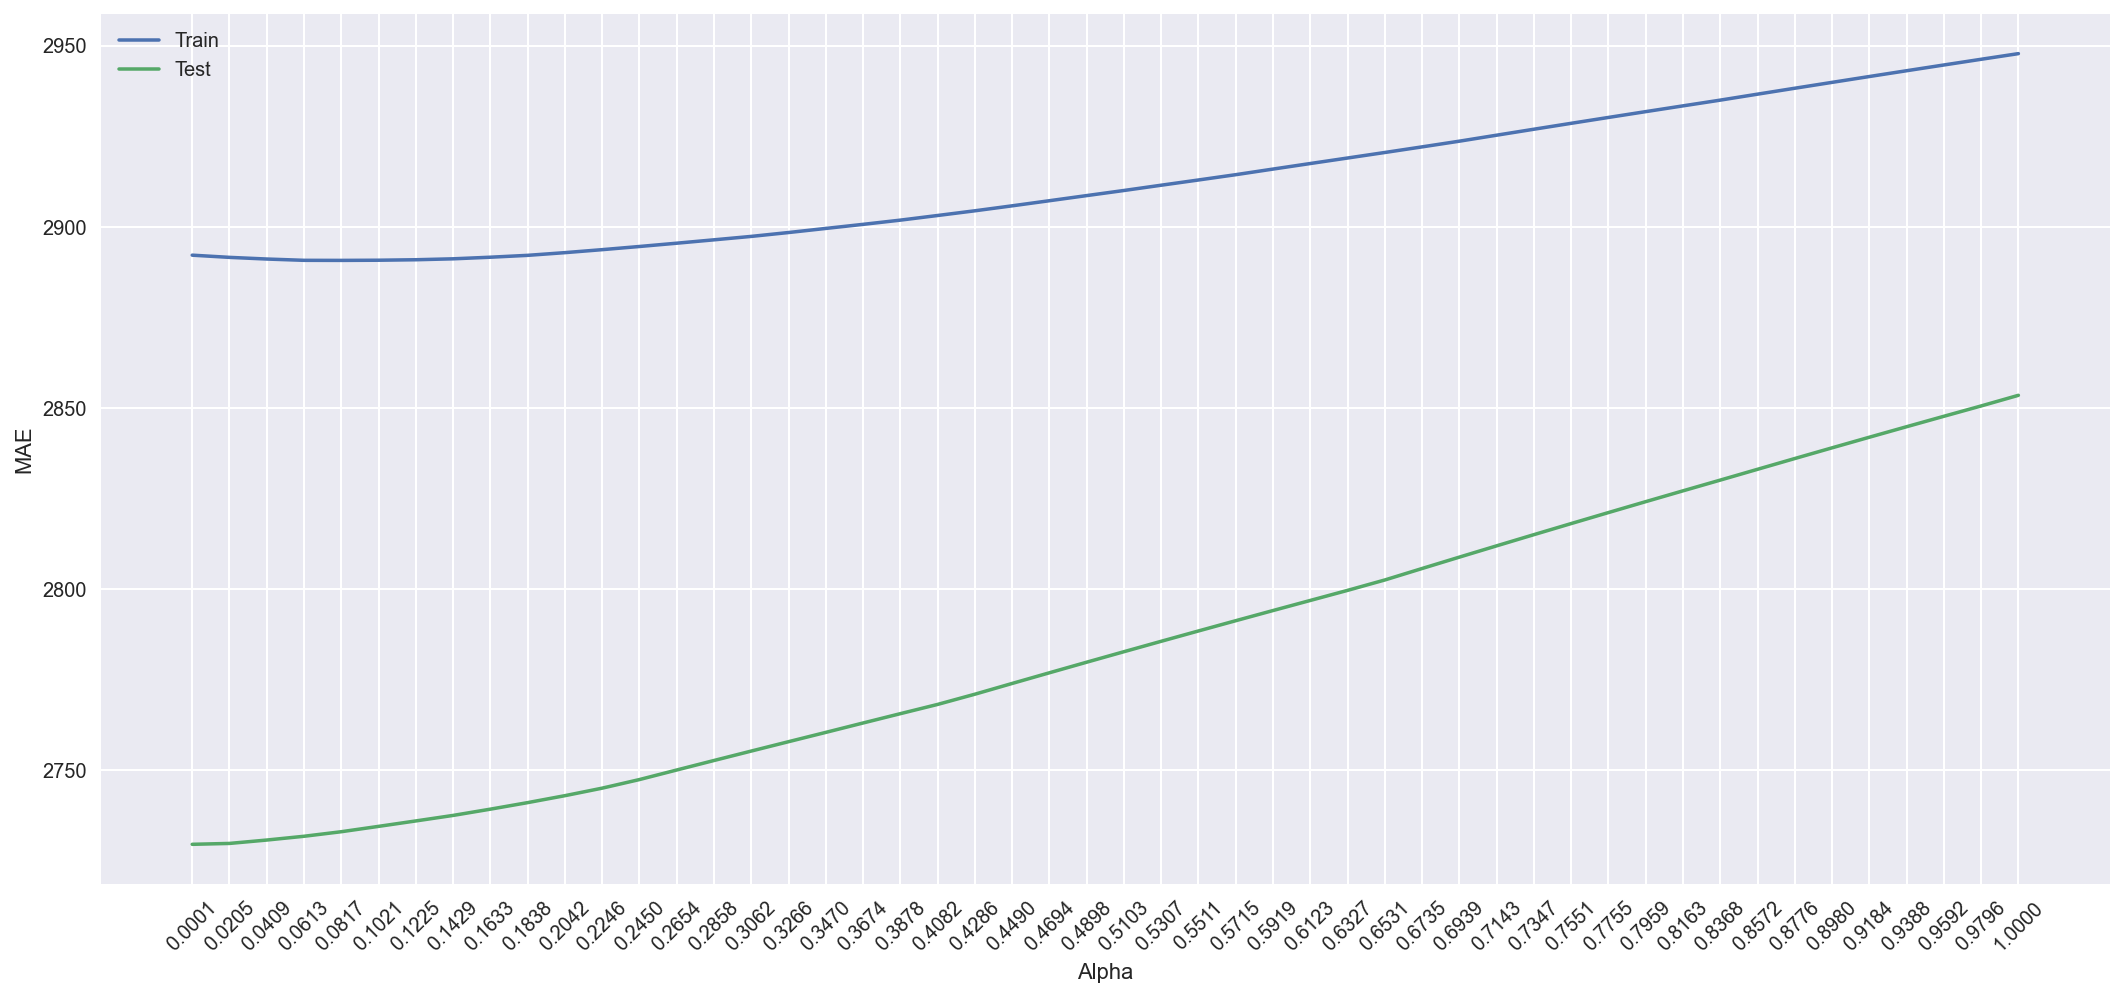

In [56]:
# Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.0001, 1, 50)

# Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for alpha in alpha_list:
    # Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=20000)
    
    # Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train)
    
    # Делаем предсказание для каждой из выборок
    # Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
    y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
    
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

# Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(18, 8)) # фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') # линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') # линейный график для тестовой выборки
ax.set_xlabel('Alpha') # название оси абсцисс
ax.set_ylabel('MAE') # название оси ординат
ax.set_xticks(alpha_list) # метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) # поворот меток на оси абсцисс
ax.legend(); # отображение легенды

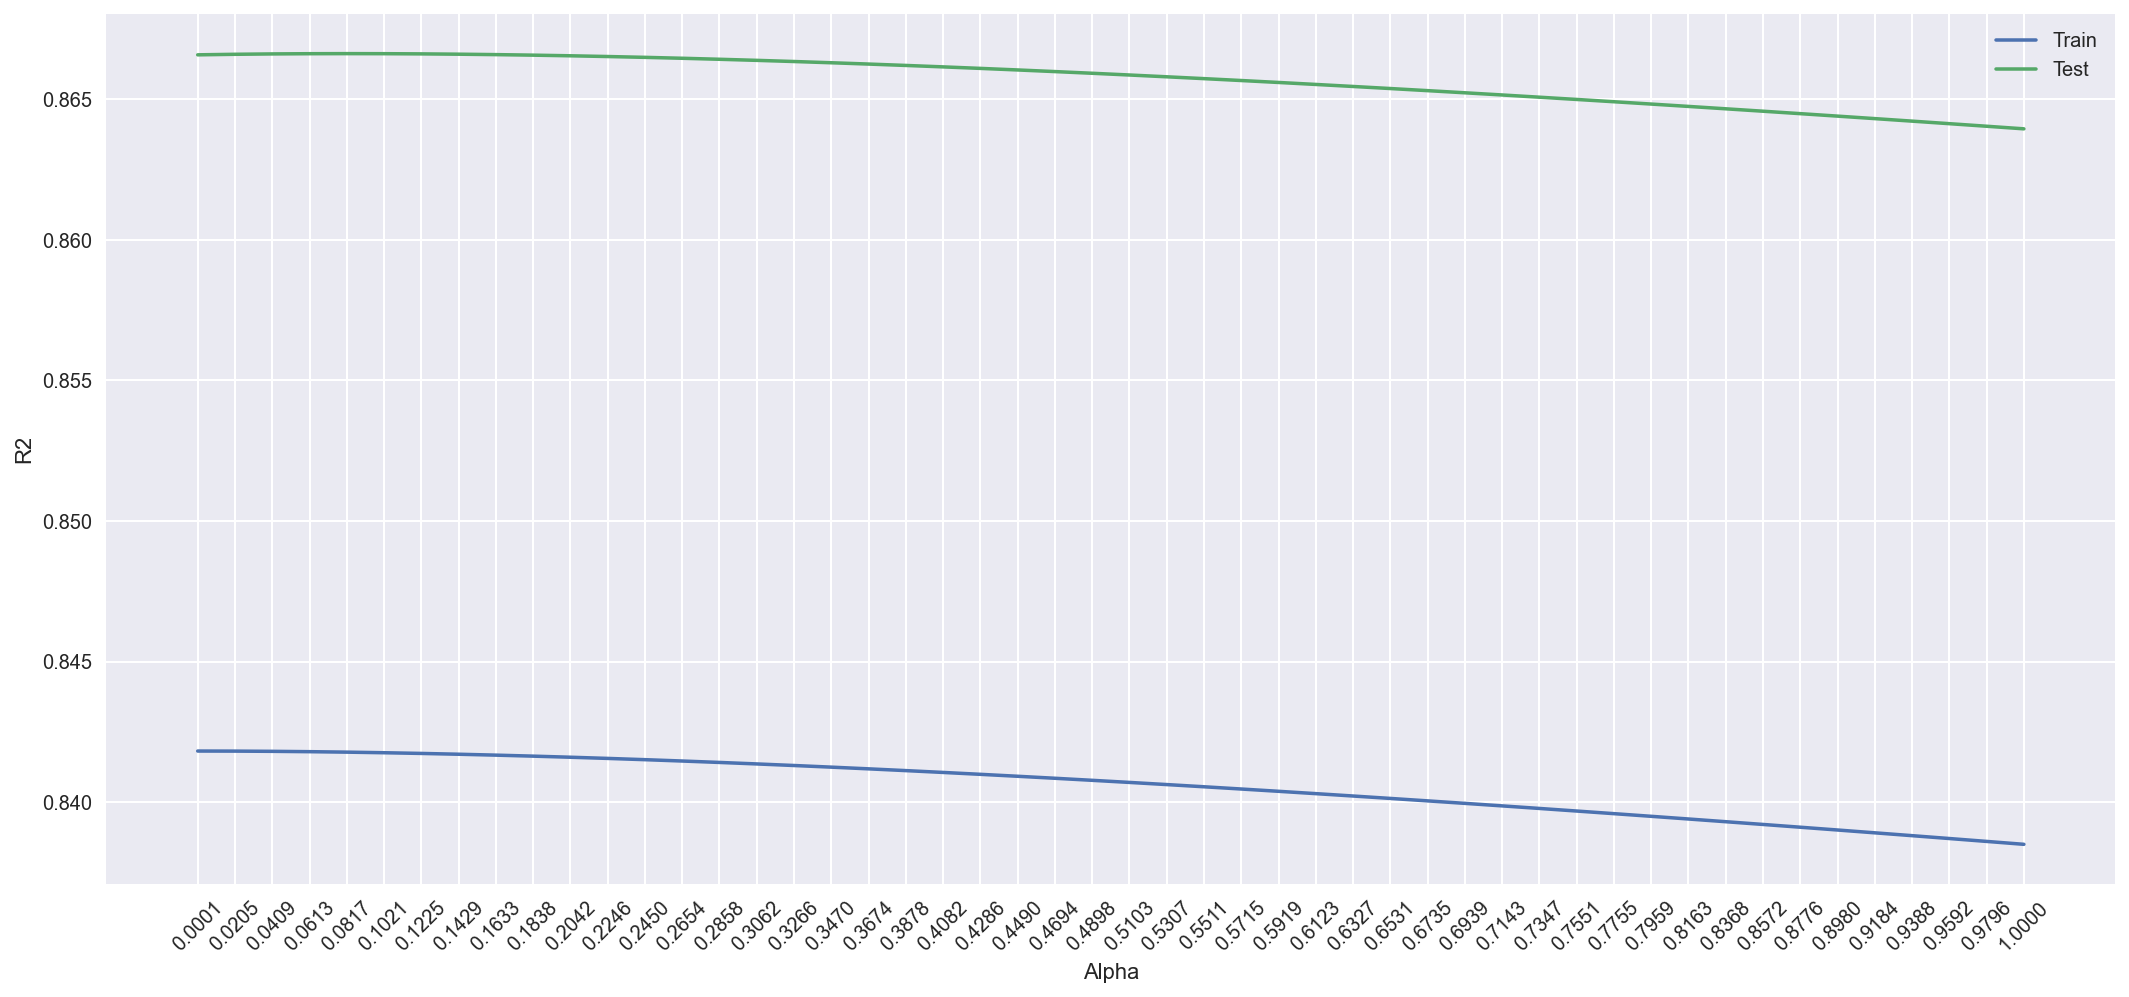

In [57]:
# Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.0001, 1, 50)

# Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for alpha in alpha_list:
    # Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=20000)
    
    # Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train)
    
    # Делаем предсказание для каждой из выборок
    # Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
    y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
    
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

# Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(18, 8)) # фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') # линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') # линейный график для тестовой выборки
ax.set_xlabel('Alpha') # название оси абсцисс
ax.set_ylabel('R2') # название оси ординат
ax.set_xticks(alpha_list) # метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) # поворот меток на оси абсцисс
ax.legend(); # отображение легенды

Ну где-то 0.06 можно выбрать коэффициент при L2 регуляризации

### Финальная модель. Альфа 0.06

In [61]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=0.06, max_iter=1000)

# Обучаем модель 
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.842
MAE: 2890.740
MAPE: 29.331

*** TEST ***
R^2: 0.867
MAE: 2731.654
MAPE: 30.152


После подбора гиперпараметра регуляризации метрики чуть улучшились

In [62]:
ridge_lr_poly.coef_

array([ 2107.68048739,  9093.91407729,  6809.70275955,  1395.22609592,
        -898.74134972,  -723.88496159,  -124.64492571,  -571.45897225,
        8320.17719499,   991.33505224, -1575.82089892,   212.58927736,
         788.33347685,  1085.47592193,  2246.77712406,  2759.15472329,
       -8942.95959619,  1788.49424757, 54101.11071875,   689.13261808,
        -915.31981696, -4526.85903852, -3508.67032306, -1982.81551497,
       -2232.26304664, -1203.40942295,    56.44635576, -1992.24263392,
       -3086.7381078 ,  1395.22609592,   295.21236242,  -584.94468117,
        -801.19386294,  1458.18275344,  -898.74134972,  1260.61239821,
        1473.93967671,   644.38704804,  -723.88496159,     0.        ,
           0.        ,  -124.64492571,     0.        ,  -571.45897225])

Коэффициенты выглядят хорошо, модель является стабильной